<a href="https://colab.research.google.com/github/InTaVia/backend-presentation-ljubljana-2023/blob/main/intavia_hands_on_9_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We begin with installing some libraries to interact with SPARQl and Rest endpoints

In [1]:
!pip install httpx SPARQLWrapper rdflib matplotlib pandas
import httpx
import SPARQLWrapper
import matplotlib
import pandas as pd

Lets start with  a simple query against the InTaVia RestAPI

In [2]:
res = httpx.get('https://intavia-backend.acdh-dev.oeaw.ac.at/v2/api/entities/search', params={'q': 'Klimt'})

When the query has been executed whatever the endoint returns is stored in the variable `res`. We can e.g. see the http status code the endpoint returned.

In [3]:
res.status_code

200

`200` means everything went well and the endpoint returned results. As the default return format is `Json` we need to convert the `Json` to python internal data before we can look at it.

In [4]:
res.json()

{'count': 7,
 'page': 1,
 'pages': 1,
 'results': [{'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L3Byb3ZpZGVkX3BlcnNvbi8yODU5MA==',
   'label': {'default': 'no label provided'},
   'kind': 'person',
   'linkedIds': [{'label': 'Österreichische Biographische Lexikon, APIS',
     'url': 'https://apis.acdh.oeaw.ac.at/entity/70679'},
    {'label': 'Gemeinsame Normdatei (GND)',
     'url': 'https://d-nb.info/gnd/136070213'}],
   'gender': {'id': 'http://ldf.fi/schema/bioc/Male',
    'label': {'default': 'male'}},
   'occupations': [{'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvb2NjdXBhdGlvbi8xMzk=',
     'label': {'default': 'Bildende und angewandte Kunst'}},
    {'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvb2NjdXBhdGlvbi80MzIz',
     'label': {'default': 'Bildende und angewandte Kunst >> Kunstgewerbler und Medailleur'}}],
   'alternativeLabels': [{'default': 'no label provided'},
    {'default': 'Klimt, Georg'}],
   'biographies': ['aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvdGV4dC83MDY3OS9iaW8='],
   'relatio

There is some metadata, such as the number of hits, the number of pages and a list of results. These results contain a lot of complicated hashes, lets look at one of them:

In [5]:
import base64
coded_string = 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L3Byb3ZpZGVkX3BlcnNvbi8zNzU3'
base64.b64decode(coded_string)

b'http://www.intavia.eu/provided_person/3757'

Now lets put what we just did in a more structured/reuseable form.
Lets define a list of queries we are interested in. In our case we use the person we already saw in the presentation: "Giuseppe Acerbi"

In [6]:
queries = ["Acerbi"]

Next we define a function that takes a query parameter and runs that query against the InTaVia Rest endpoint.

In [7]:
def query_intavia_rest(query_param: str, **kwargs) -> list:
  params = {'q': query_param}
  for key, value in kwargs.items():
    params[key] = value
  print(params)
  res = httpx.get('https://intavia-backend.acdh-dev.oeaw.ac.at/v2/api/entities/search', params=params)
  if res.status_code == 200:
    return res.json()['results']

In [8]:
for query in queries:
  res = []
  res.extend(query_intavia_rest(query))

{'q': 'Acerbi'}


In [9]:
res

[{'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L3Byb3ZpZGVkX3BlcnNvbi82Njg3',
  'label': {'default': 'Acerbi, Enrico'},
  'kind': 'person',
  'linkedIds': [{'label': 'Österreichische Biographische Lexikon, APIS',
    'url': 'https://apis.acdh.oeaw.ac.at/entity/90793'},
   {'label': 'Gemeinsame Normdatei (GND)',
    'url': 'https://d-nb.info/gnd/116241470'}],
  'gender': {'id': 'http://ldf.fi/schema/bioc/Male',
   'label': {'default': 'male'}},
  'occupations': [{'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvb2NjdXBhdGlvbi8xNTQ=',
    'label': {'default': 'Medizin'}},
   {'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvb2NjdXBhdGlvbi8yMDI=',
    'label': {'default': 'Medizin >> Mediziner'}}],
  'alternativeLabels': [{'default': 'Acerbi, Enrico'},
   {'default': 'no label provided'}],
  'biographies': ['aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvdGV4dC85MDc5My9iaW8='],
  'relations': [{'event': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvZGVhdGhldmVudC85MDc5Mw==',
    'role': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2lkbS1yb2xlL2

The return contains a lot of not resolved entities that we need to run against other endpoints

In [10]:
def resolve_events(entity: dict) -> dict:
  event_ids = list(set([rel['event'] for rel in entity['relations']]))
  role_ids = list(set([rel['role'] for rel in entity['relations']]))
  print(list(event_ids))
  res_events = httpx.post('https://intavia-backend.acdh-dev.oeaw.ac.at/v2/api/events/retrieve', json={"id": event_ids}, params={'limit': 1000})
  res_roles = httpx.post('https://intavia-backend.acdh-dev.oeaw.ac.at/v2/api/vocabularies/roles/retrieve', json={"id": role_ids})
  if res_events.status_code == 200 and res_roles.status_code == 200:
    events_data = res_events.json()['results']
    roles_data = res_roles.json()['results']
    for idx, relation in enumerate(entity['relations']):
      for event in events_data:
        if event['id'] == relation['event']:
          event.pop('relations')
          entity['relations'][idx]['event'] = event
      for role in roles_data:
        if role['id'] == relation['role']:
          entity['relations'][idx]['role'] = role
  return entity



In [11]:
resolved_entities = resolve_events(res[1])

['aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtMg==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtNg==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtMTI=', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtMTM=', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtMTA=', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvZGVhdGhldmVudC85MDc5Ng==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtNQ==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtMTY=', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtNw==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtMTU=', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtMTE=', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtOA==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtNA==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtMw==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtMQ==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2V2ZW50LzMwNzgtOQ==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2RlYXRoZXZlbnQvMzA3OA==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL2

In [12]:
resolved_entities

{'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L3Byb3ZpZGVkX3BlcnNvbi85NjQ4',
 'label': {'default': 'Acerbi, Giuseppe'},
 'kind': 'person',
 'linkedIds': [{'label': 'BiographySampo', 'url': 'http://ldf.fi/nbf/p/3078'},
  {'label': 'Wikidata', 'url': 'http://www.wikidata.org/entity/Q55007624'},
  {'label': 'Österreichische Biographische Lexikon, APIS',
   'url': 'https://apis.acdh.oeaw.ac.at/entity/90796'},
  {'label': 'Gemeinsame Normdatei (GND)',
   'url': 'https://d-nb.info/gnd/119372843'}],
 'gender': {'id': 'http://ldf.fi/schema/bioc/Male',
  'label': {'default': 'male'}},
 'occupations': [{'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL29jY3VwYXRpb24vMzY4MzQ=',
   'label': {'default': 'composer'}},
  {'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvb2NjdXBhdGlvbi8xMzU=',
   'label': {'default': 'Naturwissenschaft'}},
  {'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2JzL29jY3VwYXRpb24vMzU3OTAzNQ==',
   'label': {'default': 'travel writer'}},
  {'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvb2NjdXBhdGlvbi8xMjg=',
   '

# Compare data with Wikidata using SPARQL

lets create a SPARQL query to compare the date of birth in wikidata with those from InTaVia.
We start with getting the birth dates from our InTaVia data

In [13]:
birth_dates_acerbi = []
for event in resolved_entities['relations']:
  if event['role']['label']['default'] == 'Born Person':
    print(event['event']['startDate'])
    birth_dates_acerbi.append(event['event']['startDate'])

1773-01-01
1773-05-03


The birth dates are now stored in `birth_dates_acerbi`

In [14]:
birth_dates_acerbi

['1773-01-01', '1773-05-03']

Next we need the wikidata id.

In [15]:
for linked_id in resolved_entities['linkedIds']:
  if linked_id['label'] == 'Wikidata':
    print(linked_id)

{'label': 'Wikidata', 'url': 'http://www.wikidata.org/entity/Q55007624'}


Lets write the SPARQL query to get the same data from Wikidata. For writing Wikidata queries the Wikidata query service is a handy application. Lets go [there](https://query.wikidata.org/).

In [16]:
sparql = """
select * where {
BIND(<http://www.wikidata.org/entity/Q55007624> AS ?acerbi)
?acerbi wdt:P31 wd:Q5 ;
        wdt:P569 ?date_of_birth
}
"""

In [17]:
from SPARQLWrapper import SPARQLWrapper, JSON
sparql_wikidata = SPARQLWrapper("https://query.wikidata.org/sparql")
sparql_wikidata.setQuery(sparql)
sparql_wikidata.setReturnFormat(JSON)
results = sparql_wikidata.query().convert()

In [18]:
results

{'head': {'vars': ['acerbi', 'date_of_birth']},
 'results': {'bindings': [{'acerbi': {'type': 'uri',
     'value': 'http://www.wikidata.org/entity/Q55007624'},
    'date_of_birth': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
     'type': 'literal',
     'value': '1773-05-03T00:00:00Z'}}]}}

In [19]:
for date in birth_dates_acerbi:
  if date in results['results']['bindings'][0]['date_of_birth']['value']:
    print(f"{date} found in wikidata")

1773-05-03 found in wikidata


# Create a simple visualization in Python using the API

In [20]:
institutions = query_intavia_rest('Künstlerhaus', kind=['group'])

{'q': 'Künstlerhaus', 'kind': ['group']}


In [21]:
kuenstlerhaus = institutions[9]

In [22]:
kuenstlerhaus

{'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L3Byb3ZpZGVkX2dyb3VwLzI0NDc=',
 'label': {'default': 'Genossenschaft der Bildenden Künstler Wiens (Künstlerhaus)'},
 'kind': 'group',
 'linkedIds': [{'label': 'Österreichische Biographische Lexikon, APIS',
   'url': 'https://apis.acdh.oeaw.ac.at/entity/98141'},
  {'label': 'Gemeinsame Normdatei (GND)',
   'url': 'https://d-nb.info/gnd/3009578-5'}],
 'alternativeLabels': [{'default': 'Genossenschaft der Bildenden Künstler Wiens (Künstlerhaus)'}],
 'relations': [{'event': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzExODgyNA==',
   'role': 'aHR0cDovL2xkZi5maS9zY2hlbWEvYmlvYy9Hcm91cF9SZWxhdGlvbnNoaXBfUm9sZQ=='},
  {'event': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwOTY4MA==',
   'role': 'aHR0cDovL2xkZi5maS9zY2hlbWEvYmlvYy9Hcm91cF9SZWxhdGlvbnNoaXBfUm9sZQ=='},
  {'event': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzExNjI4MQ==',
   'role': 'aHR0cDovL2xkZi5maS9zY2hlbWEvYmlvYy9Hcm91cF9SZWxhdGlvbnNoaXBfUm9sZQ=='},
  {'event': 'aHR0cDovL3d3dy5pbnRh

In [23]:
extended_kuenstlerhaus = resolve_events(kuenstlerhaus)

['aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzk4NjIz', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwNDQ5Nw==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwNTAwMQ==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwOTExMw==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwMjgzNQ==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzk5MDg3', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwODYwNw==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzExNjMzMA==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwODk4MQ==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwNjc4OQ==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwMzE0OQ==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzExMDExMg==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzExOTk3NA==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwMTYwMA==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwMDAxOA==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzEwODMxMg==', 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLz

In [24]:
extended_kuenstlerhaus

{'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L3Byb3ZpZGVkX2dyb3VwLzI0NDc=',
 'label': {'default': 'Genossenschaft der Bildenden Künstler Wiens (Künstlerhaus)'},
 'kind': 'group',
 'linkedIds': [{'label': 'Österreichische Biographische Lexikon, APIS',
   'url': 'https://apis.acdh.oeaw.ac.at/entity/98141'},
  {'label': 'Gemeinsame Normdatei (GND)',
   'url': 'https://d-nb.info/gnd/3009578-5'}],
 'alternativeLabels': [{'default': 'Genossenschaft der Bildenden Künstler Wiens (Künstlerhaus)'}],
 'relations': [{'event': {'id': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2FwaXMvY2FyZWVyLzExODgyNA==',
    'label': {'default': 'Kautsky, Jan war o. Mitglied Genossenschaft der Bildenden Künstler Wiens (Künstlerhaus)'},
    'kind': 'aHR0cDovL3d3dy5pbnRhdmlhLmV1L2lkbS1jb3JlL0NhcmVlcg==',
    'startDate': '1866-08-04'},
   'role': {'id': 'aHR0cDovL2xkZi5maS9zY2hlbWEvYmlvYy9Hcm91cF9SZWxhdGlvbnNoaXBfUm9sZQ==',
    'label': {'default': 'Group Relationship Role (bioc)'},
    'related': [{'relation_type': 'broader',
      'rel

The enriched events contain memberships in the Künstlerhaus, so lets extract the start dates and chart them on a bar chart

In [25]:
join_dates_kuenstlerhaus = {}
for event in extended_kuenstlerhaus['relations']:
  if 'startDate' in event['event']:
    year = event['event']['startDate'][:4]
    if year in join_dates_kuenstlerhaus:
      join_dates_kuenstlerhaus[year] += 1
    else:
      join_dates_kuenstlerhaus[year] = 1

In [26]:
join_dates_kuenstlerhaus

{'1866': 2,
 '1863': 3,
 '1870': 11,
 '1861': 60,
 '1894': 4,
 '1869': 14,
 '1885': 5,
 '1887': 4,
 '1871': 6,
 '1875': 4,
 '1868': 8,
 '1890': 7,
 '1880': 17,
 '1961': 1,
 '1939': 3,
 '1923': 4,
 '1913': 1,
 '1884': 7,
 '1864': 2,
 '1920': 5,
 '1872': 10,
 '1892': 3,
 '1902': 5,
 '1908': 6,
 '1893': 5,
 '1895': 7,
 '1882': 5,
 '1912': 1,
 '1927': 3,
 '1941': 1,
 '1905': 6,
 '1888': 3,
 '1909': 3,
 '1899': 3,
 '1874': 4,
 '1891': 5,
 '1883': 7,
 '1889': 2,
 '1921': 6,
 '1922': 2,
 '1930': 2,
 '1903': 4,
 '1911': 4,
 '1881': 5,
 '1900': 5,
 '1896': 7,
 '1862': 4,
 '1924': 3,
 '1901': 4,
 '1878': 1,
 '1919': 1,
 '1907': 3,
 '1917': 1,
 '1873': 3,
 '1886': 4,
 '1910': 1,
 '1929': 1,
 '1938': 1,
 '1877': 1,
 '1898': 1,
 '1933': 1,
 '1876': 2,
 '1928': 2,
 '1865': 1,
 '1897': 1}

In [27]:
df = pd.DataFrame(sorted([{'year': int(key), 'value': value} for key, value in join_dates_kuenstlerhaus.items()], key=lambda d: d['year']))

In [28]:
df

,year,value
0,1861,60
1,1862,4
2,1863,3
3,1864,2
4,1865,1
...,...,...
60,1933,1
61,1938,1
62,1939,3
63,1941,1


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['year'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['value'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['year'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['value'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df, *[[['year', 'value']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['year', 'value', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['year', 'count()', None], **{})
chart

<Axes: title={'center': 'Entries to Künstlerhaus per year'}, xlabel='year'>

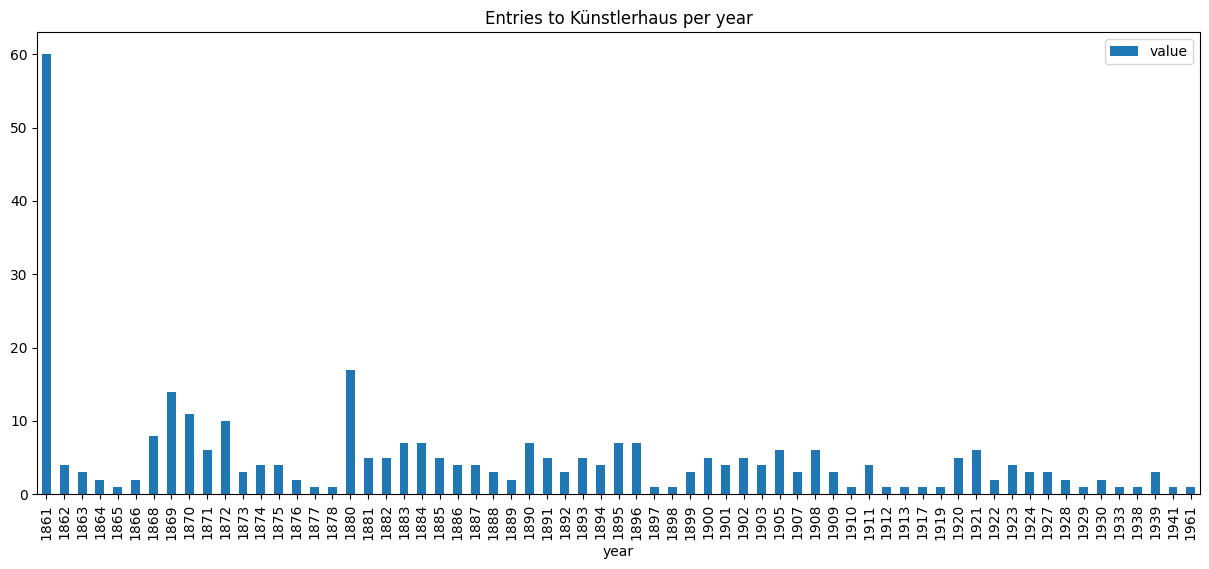

In [29]:
df.plot.bar(x='year', y='value', figsize=(15, 6), title="Entries to Künstlerhaus per year")